# Design and test a Butterworth high-pass filter

**NOTE**: Parallels the low-pass filter; adjusted to a high-pass filter transfer function.

This document describes how to design a Butterworth **high-pass** filter with a cutoff frequency $\omega_c$ and compute the discrete coefficients so that it can be implemented on hardware.

In [221]:
# Packages and adjustments to the figures
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import math
plt.rcParams["figure.figsize"] = 10,5
plt.rcParams["font.size"] = 16
plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})

## 1. Generate a test signal
 
* A simple test signal $\boldsymbol{y} = \{ y_i \}$ is generated with a fixed sampling frequency using the function:

$$y(t) = m_0 \sin(2\pi f_0 t) + m_1 \sin(2\pi f_1 t)$$

* The power spectrum is plotted as the magnitude of the discrete fourier transform (DFT): $|\hat{\boldsymbol{y}}|$

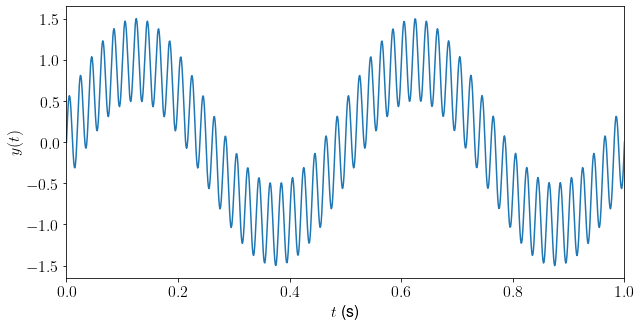

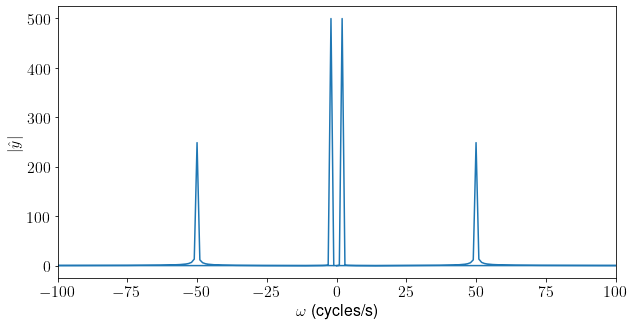

In [222]:
# Generate a signal
samplingFreq = 1000; # sampled at 1 kHz = 1000 samples / second
tlims = [0,1]        # in seconds
signalFreq = [2,50]; # Cycles / second
signalMag = [1,0.5]; # magnitude of each sine
t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*samplingFreq)
y = signalMag[0]*np.sin(2*math.pi*signalFreq[0]*t) + signalMag[1]*np.sin(2*math.pi*signalFreq[1]*t)

# Compute the Fourier transform
yhat = np.fft.fft(y);
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq); # the frequencies in cycles/s

# Plot the signal
plt.figure()
plt.plot(t,y);
plt.ylabel("$y(t)$");
plt.xlabel("$t$ (s)");
plt.xlim([min(t),max(t)]);

# Plot the power spectrum
plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.xlim([-100,100]);
plt.xlabel("$\omega$ (cycles/s)");
plt.ylabel("$|\hat{y}|$");

## 2. Butterworth high-pass filter transfer function

This document does not derive the formula for a Butterworth filter. Instead, it uses the standard form with DC gain $G=1$.

* A cutoff frequency $\omega_c$ is selected
* The Butterworth low-pass filter transfer function with $\omega_c = 1$ can be written as (see https://en.wikipedia.org/wiki/Butterworth_filter)
$$H(s) = \frac{1}{\sum_0^{n} a_k s^k}$$
where $n$ is the order of the filter. The coefficients are given by the recursion formula:
$$a_{k+1} = \frac{\cos( k \gamma )}{\sin((k+1)\gamma)} a_k$$
with $a_0 = 1$ and $\gamma = \frac{\pi}{2n}$.

* The Butterworth polynomial is
$$B_n(s) = \sum_{k=0}^n a_k s^k$$
* The high-pass filter with a cutoff frequency $\omega_c$ can be found using the transformation $s \rightarrow \frac{\omega_c}{s} $, so
$$B_n = \sum_{k=0}^n a_k \left(\frac{\omega_c}{s}\right)^k = \sum_{k=0}^n a_k {\omega_c}^k  s^{-k}$$

* The transfer function of an $n^{\text{th}}$ order filter is therefore
$$H(s) = \frac{s^n}{\sum_0^{n} a_{k} {\omega_c}^{k}  s^{n-k}}$$

* Setting $j = n-k$:
$$H(s) = \frac{s^n}{\sum_0^{n} a_{n-j} {\omega_c}^{n-j}  s^{j}}$$

* For convenience set $c_j = a_{n-j} {\omega_c}^{n-j}$, so:

$$H(s) = \frac{s^n}{\sum_0^{n} c_{j} s^{j}}$$

In [223]:
# Butterworth filter
wc = 2*np.pi*20; # cutoff frequency (rad/s)
n = 2; # Filter order

# Compute the Butterworth filter coefficents
a = np.zeros(n+1);
gamma = np.pi/(2.0*n);
a[0] = 1; # first coef is always 1
for k in range(0,n):
    rfac = np.cos(k*gamma)/np.sin((k+1)*gamma);
    a[k+1] = rfac*a[k]; # Other coefficients by recursion

print("Butterworth polynomial coefficients a_i:                " + str(a))

# Compute the coefficients
c = np.zeros(n+1);
for j in range(0,n+1):
    c[j] = a[n-j]*pow(wc,n-j)

# The transfer function form orders the terms in descending order
# So we have to flip the coefficients
c_flip = np.flip(c)
print(c)

print("Butterworth coefficients with frequency adjustment c_i: " + str(c))

Butterworth polynomial coefficients a_i:                [1.         1.41421356 1.        ]
[1.57913670e+04 1.77715318e+02 1.00000000e+00]
Butterworth coefficients with frequency adjustment c_i: [1.57913670e+04 1.77715318e+02 1.00000000e+00]


[1. 0. 0.]
[1.00000000e+00 1.77715318e+02 1.57913670e+04]


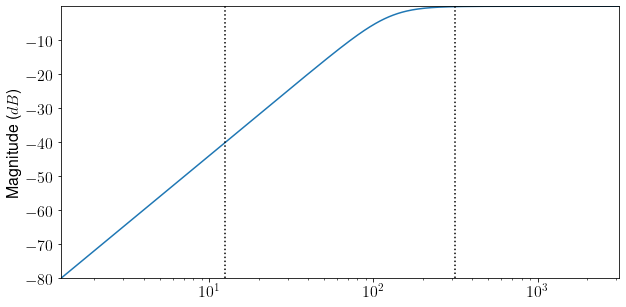

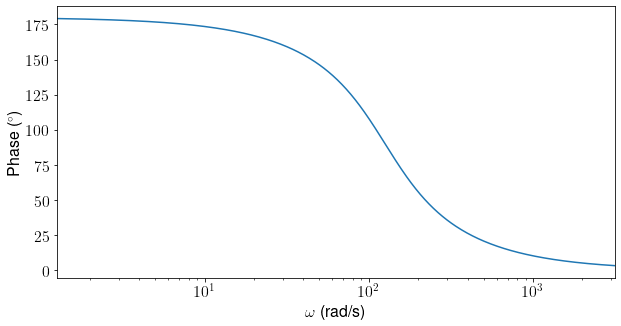

In [224]:
num = np.zeros(n+1) 
num[0] = 1;         # transfer function numerator coefficients 
den = c_flip;              # transfer function denominator coefficients
highPass = signal.TransferFunction(num,den) # Transfer function

print(num)
print(den)

# Generate the bode plot
w = np.logspace( np.log10(min(signalFreq)*2*np.pi/10), np.log10(max(signalFreq)*2*np.pi*10), 500 )
w, mag, phase = signal.bode(highPass,w)

# Magnitude plot
plt.figure()
plt.semilogx(w, mag)
for sf in signalFreq:
    plt.semilogx([sf*2*np.pi,sf*2*np.pi],[min(mag),max(mag)],'k:')
plt.ylabel("Magnitude ($dB$)")
plt.xlim([min(w),max(w)])
plt.ylim([min(mag),max(mag)])

# Phase plot
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.ylabel("Phase ($^\circ$)")
plt.xlabel("$\omega$ (rad/s)")
plt.xlim([min(w),max(w)])
plt.show()


## 3. Discrete transfer function

To implement the low-pass filter on hardware, you need to compute the discrete transfer function using the signal's sampling frequency.
* The time step is $\Delta t = 1/f_s$
* Compute the discrete transfer function using Tustin's method by setting $s = \frac{2}{\Delta t} \left( \frac{1-z^{-1}}{1+z^{-1}} \right)$
* Why do it yourself? The <code>to_discrete</code> method computes the bilinear transform (Tustin's method when $\alpha = 1/2$)

In [227]:
# Compute the discrete low pass with delta_t = 1/samplingFrequency
dt = 1.0/samplingFreq;
discreteHighPass = highPass.to_discrete(dt,method='tustin',alpha=0.5)
print(discreteHighPass)

TransferFunctionDiscrete(
array([ 0.91507592, -1.83015184,  0.91507592]),
array([ 1.        , -1.82292669,  0.83737699]),
dt: 0.001
)


## 4. Filter coefficients

We want to find the filter coefficients for the discrete update:
$$y[n] = a_1 y[n-1] + a_2 y[n-2] + ... + b_0 x[n] + b_1 x[n-1] + ...$$

The coefficients can be taken directly from the discrete transfer function of the filter in the form:
$$H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2} + \ldots}{1 - a_1 z^{-1} - a_2 z^{-2} + \ldots}$$

(This is a result of taking the Z-transform which is not shown here)

Compare this to a transfer function with coefficients
<code>
num = [b_0, b_1, b_2]
den = [1, a_1, a_2]
</code>
is 
$$H(z) = \frac{b_0 z^2 + b_1 z + b_2}{z^2 + a_1 z + a_2}$$
which is equivalent to
$$H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{1 + a_1 z^{-1} + a_2 z^{-2}}$$
So you can take the coefficients in the same order that they are defined in the numerator and denominator of the transfer function object. The only difference is that the **coefficients in the denominator need a negative sign**.

* To filter the signal, apply the filter using the discrete update
* The filtered signal and filtered signal power spectrum are plotted alongside the unfiltered signal

Filter coefficients b_i: [ 0.91507592 -1.83015184  0.91507592]
Filter coefficients a_i: [ 1.82292669 -0.83737699]


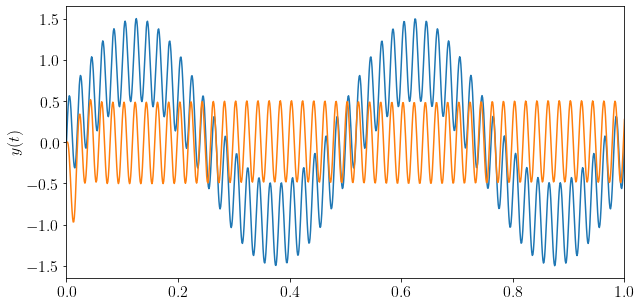

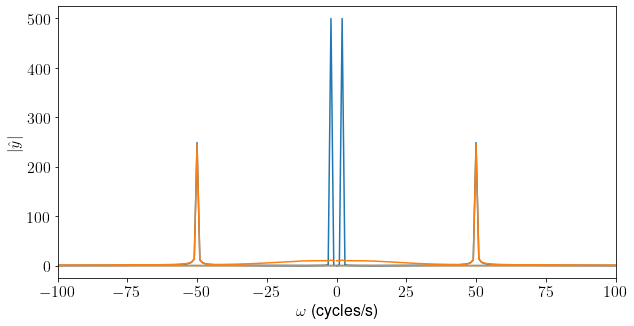

In [228]:
# The coefficients from the discrete form of the filter transfer function (but with a negative sign)
b = discreteHighPass.num;
a = -discreteHighPass.den;
print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a[1:]))

# Filter the signal
Nb = len(b)
yfilt = np.zeros(len(y));
for m in range(3,len(y)):
    yfilt[m] = b[0]*y[m];
    for i in range(1,Nb):
        yfilt[m] += a[i]*yfilt[m-i] + b[i]*y[m-i];
    
# View the result
# Plot the signal
plt.figure()
plt.plot(t,y);
plt.plot(t,yfilt);
plt.ylabel("$y(t)$")
plt.xlim([min(t),max(t)]);

# Generate Fourier transform
yfilthat = np.fft.fft(yfilt)
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq)

plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.plot(fcycles,np.absolute(yfilthat));
plt.xlim([-100,100]);
plt.xlabel("$\omega$ (cycles/s)");
plt.ylabel("$|\hat{y}|$");
